In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # UserWarning 억제
warnings.filterwarnings("ignore", category=FutureWarning) # FutureWarning 억제

# 심볼 목록 정의
crypto_symbols = ["BTC-USD", "SOL-USD", "XRP-USD", "DOGE-USD", "ADA-USD", "APT21794-USD", "AVAX-USD","COTI-USD", "CRV-USD", "ENS-USD",
                  "LTC-USD","FIL-USD","FTM-USD","HBAR-USD", "NEAR-USD", "ONDO-USD","XLM-USD","FTM-USD"]

# 현재 날짜와 시간 가져오기
now = datetime.now()
current_hour = now.replace(minute=0, second=0, microsecond=0)  # 현재 시각의 시 만큼 자르고 더 작은 단위는 0으로 설정

# 데이터 가져오기
crypto_data = yf.download(crypto_symbols, start=current_hour - timedelta(days=30), end=current_hour, interval="1h").fillna(method='ffill')

# Close 가격만 선택
close_prices = crypto_data['Close']

# 오늘 포함된 데이터 확인
print(close_prices.tail())
print(current_hour)

[*********************100%***********************]  17 of 17 completed

Ticker                      ADA-USD  APT21794-USD   AVAX-USD       BTC-USD  \
Datetime                                                                     
2024-11-30 09:00:00+00:00  1.106400     13.078161  45.605164  96802.257812   
2024-11-30 10:00:00+00:00  1.081735     12.885750  44.573696  96193.687500   
2024-11-30 11:00:00+00:00  1.094073     12.957141  44.708019  96298.195312   
2024-11-30 12:00:00+00:00  1.080300     13.020216  45.450394  96572.257812   
2024-11-30 13:00:00+00:00  1.080379     13.023407  45.459137  96584.132812   

Ticker                     COTI-USD   CRV-USD  DOGE-USD    ENS-USD   FIL-USD  \
Datetime                                                                       
2024-11-30 09:00:00+00:00  0.154885  0.564316  0.430319  43.181900  6.217781   
2024-11-30 10:00:00+00:00  0.149614  0.553793  0.420533  42.984158  6.111325   
2024-11-30 11:00:00+00:00  0.150913  0.588524  0.423306  44.681652  6.271516   
2024-11-30 12:00:00+00:00  0.155344  0.620730  0.4226

In [22]:
# 일반 수익률 계산
returns = crypto_data['Close'].pct_change(fill_method=None).dropna()  # 결측치를 채우지 않음

# 변동성 계산 함수
def calculate_volatility(data, window):
    return data.rolling(window=window).std()

# 각 주기에 대한 변동성 계산
volatility_1h = returns.std() * np.sqrt(1)  # 1시간 변동성
volatility_12h = returns.resample('12h').std().mean() * np.sqrt(12)  # 4시간 변동성
volatility_1D = returns.resample('D').std().mean() * np.sqrt(24)  # 일간 변동성
volatility_3D = returns.resample('3D').std().mean() * np.sqrt(24 * 3)  # 주간 변동성

# 포트폴리오 기대 수익률 (평균으로 설정)
portfolio_return = returns.mean()

# 샤프 지수 계산 (일간 기반)
sharpe_1D = (portfolio_return * 24 - 0) / volatility_1D  # 일간 샤프 비율


# 결과를 데이터프레임으로 정리
volatility_df = pd.DataFrame({
    '1H': (volatility_1h * 100).round(1),
    '12H': (volatility_12h * 100).round(1),
    '1D': (volatility_1D * 100).round(1),
    '3D': (volatility_3D * 100).round(1),
    'Sharpe': sharpe_1D.round(2),
})

# Daily 기준으로 내림차순 정렬
volatility_df_sorted = volatility_df.sort_values(by='1D')

# 결과 출력
print(volatility_df_sorted)

               1H  12H   1D    3D  Sharpe
Ticker                                   
BTC-USD       0.6  1.8  2.6   4.7    0.40
SOL-USD       0.9  3.0  4.3   7.4    0.29
LTC-USD       1.2  3.5  5.1   8.8    0.26
FIL-USD       1.2  4.0  5.7   9.9    0.36
AVAX-USD      1.2  4.0  5.7  10.0    0.37
APT21794-USD  1.3  4.2  6.0  10.4    0.22
NEAR-USD      1.4  4.5  6.4  11.1    0.30
ONDO-USD      1.4  4.6  6.6  11.8    0.32
XRP-USD       1.6  4.9  6.9  12.2    0.66
CRV-USD       1.5  5.0  7.0  12.9    0.47
COTI-USD      1.6  4.9  7.0  12.4    0.28
FTM-USD       1.6  5.0  7.2  12.3    0.26
ADA-USD       1.6  4.9  7.2  12.6    0.56
ENS-USD       1.8  5.2  7.6  14.9    0.48
DOGE-USD      1.8  5.4  7.8  13.5    0.45
XLM-USD       2.4  6.3  8.9  16.1    0.72
HBAR-USD      2.3  6.3  9.0  16.4    0.53


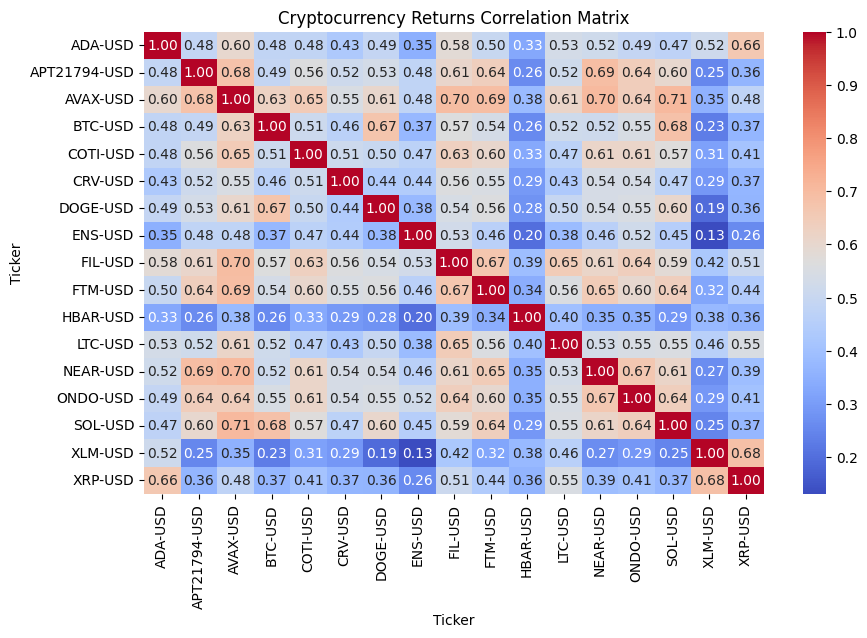

In [23]:
# 상관관계 계산
correlation_matrix = returns.corr()

# 상관관계 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Cryptocurrency Returns Correlation Matrix')
plt.show()

In [24]:
### 최근 종가 가져오기
recent_close_prices = crypto_data['Close'].iloc[-1]  # 최신 종가

# recent_close_prices['BONK-USD'] = recent_close_prices['BONK-USD'] * 1000

# 변동성을 기준으로 가격 계산
Down_prices_1D = recent_close_prices * (1 - (volatility_1D))  # 12시간 변동성 적용
Down_prices_3D = recent_close_prices * (1 - (volatility_3D))  # 일간 변동성 적용
Up_prices_1D = recent_close_prices * (1 + (volatility_1D))  # 일간 변동성 적용
Up_prices_3D = recent_close_prices * (1 + (volatility_3D))  # 일간 변동성 적용


# 결과를 새로운 데이터프레임으로 정리
adjusted_prices_df = pd.DataFrame({
    'Down Price (1D)': Down_prices_1D.round(4),
    'Down Price (3D)': Down_prices_3D.round(4),
    'Up Price (1D)': Up_prices_1D.round(4),
    'Up Price (3D)': Up_prices_3D.round(4)
})
# 결과 출력
print("\nAdjusted Prices DataFrame:")
print(adjusted_prices_df)


Adjusted Prices DataFrame:
              Down Price (1D)  Down Price (3D)  Up Price (1D)  Up Price (3D)
Ticker                                                                      
ADA-USD                1.0031           0.9440         1.1576         1.2167
APT21794-USD          12.2377          11.6678        13.8091        14.3790
AVAX-USD              42.8635          40.9248        48.0547        49.9934
BTC-USD            94047.6469       92070.4480     99120.6188    101097.8176
COTI-USD               0.1444           0.1361         0.1662         0.1745
CRV-USD                0.5773           0.5408         0.6641         0.7007
DOGE-USD               0.3900           0.3656         0.4556         0.4801
ENS-USD               42.5831          39.2326        49.5698        52.9203
FIL-USD                5.9848           5.7186         6.7138         6.9800
FTM-USD                0.9916           0.9369         1.1453         1.2001
HBAR-USD               0.1510           0.1388  

In [25]:
returns = crypto_data['Close'].pct_change().dropna()

# 사용자로부터 각 암호화폐의 수량 입력 받기
quantities = ({
  "BTC-USD": 000,
  "SOL-USD": 000,
  "XRP-USD": 3000,
  "DOGE-USD": 000,
  "ADA-USD": 2000,
  "APT21794-USD": 75,
  "AVAX-USD": 000,
  "COTI-USD": 6000,
  "CRV-USD": 3000,
  "ENS-USD": 40,
  "LTC-USD": 000,
  "FIL-USD": 150,
  "FTM-USD": 1500,
  "HBAR-USD": 10000,
  "NEAR-USD": 150,
  "ONDO-USD": 1500,
  "XLM-USD": 000
})

# 현재 가격 가져오기
latest_prices = crypto_data['Close'].iloc[-1]

# 포트폴리오의 각 암호화폐의 현재 가치를 계산
portfolio_value = sum(latest_prices[symbol] * quantities[symbol] for symbol in quantities.keys())

# 포트폴리오 비중 계산
weights = {symbol: (latest_prices[symbol] * quantities[symbol]) / portfolio_value for symbol in quantities.keys()}

# Pandas Series로 변환
weights = pd.Series(weights)

# 공분산 행렬 계산
cov_matrix = returns.cov()

# 포트폴리오 변동성 계산 (일간으로 변환)
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
portfolio_volatility_hourly = np.sqrt(portfolio_variance)
portfolio_volatility_daily = portfolio_volatility_hourly * np.sqrt(24)  # 하루 동안의 변동성

# 일간 포트폴리오 기대 수익률 계산
portfolio_mean_hourly = np.dot(weights.T, returns.mean())
portfolio_mean_daily = (1 + portfolio_mean_hourly) ** 24 - 1  # 복리 수익률 변환

# 95% 신뢰수준에서의 VaR 계산
z_score = norm.ppf(0.05)
var_95_daily = -z_score * portfolio_volatility_daily * portfolio_value  # 포트폴리오 가치

# 결과 출력
print(f"Daily Portfolio Volatility: {portfolio_volatility_daily:.2%}")
print(f"Daily Portfolio Mean: {portfolio_mean_daily:.2%}")
print(f"95% VaR (daily, value): ${var_95_daily:,.2f} ({var_95_daily/portfolio_value:.2%})")
print(f"Portfolio_Value: {portfolio_value:,.2f}")

Daily Portfolio Volatility: 5.43%
Daily Portfolio Mean: 2.53%
95% VaR (daily, value): $1,819.06 (8.92%)
Portfolio_Value: 20,382.89


In [26]:
# 각 코인별 VaR 계산 및 출력
individual_vars = []  # 각 코인별 VaR를 저장할 리스트

for symbol in crypto_symbols:
    weight = weights[symbol]
    if weight > 0:  # 롱 포지션이 있는 경우에만 VaR 계산
        individual_mean = returns[symbol].mean() * 24  # 일간 기대 수익률
        individual_volatility = returns[symbol].std() * np.sqrt(24)  # 일간 변동성

        individual_var_dollar = weight * (-z_score * individual_volatility * portfolio_value)  # 금액 손실
        individual_var_percent = (individual_var_dollar / portfolio_value) * 100  # 퍼센트 손실

        print(f"{symbol} : ${individual_var_dollar:.2f} ({individual_var_percent:.2f}%)")
        individual_vars.append(individual_var_dollar)  # VaR를 리스트에 추가

# 95% VaR의 총합 계산 및 출력
total_var_95 = sum(individual_vars)
print(f"\nTotal 95% VaR (daily, value): ${total_var_95:.2f}")

XRP-USD : $726.74 (3.57%)
ADA-USD : $280.22 (1.37%)
APT21794-USD : $103.84 (0.51%)
COTI-USD : $118.23 (0.58%)
CRV-USD : $231.79 (1.14%)
ENS-USD : $263.21 (1.29%)
FIL-USD : $95.31 (0.47%)
FTM-USD : $205.26 (1.01%)
HBAR-USD : $306.31 (1.50%)
NEAR-USD : $114.74 (0.56%)
ONDO-USD : $209.22 (1.03%)
FTM-USD : $205.26 (1.01%)

Total 95% VaR (daily, value): $2860.13


In [29]:
# 공분산 행렬 계산
cov_matrix = returns.cov()
mean_returns = returns.mean()

# 코인 그룹 나누기 (예시) - 실제 코인 목록에 맞춰 수정해야 합니다.
first_group = ["BTC-USD", "SOL-USD","XRP-USD"]
second_group = ["DOGE-USD", "ADA-USD", "APT21794-USD", "AVAX-USD","COTI-USD", "CRV-USD", "ENS-USD",
                  "LTC-USD","FIL-USD","FTM-USD","HBAR-USD", "NEAR-USD", "ONDO-USD","XLM-USD","FTM-USD"]

# crypto_symbols 리스트 중복 제거
crypto_symbols = list(set(first_group + second_group))

# first_group와 second_group에 해당하는 인덱스 얻기
first_indices = [crypto_symbols.index(symbol) for symbol in first_group]
second_indices = [crypto_symbols.index(symbol) for symbol in second_group]


# 최소 변동성과 최대 샤프 비율 최적화 함수 (수정)
def optimize_portfolio(weights):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return -sharpe_ratio # 샤프 비율 최대화를 위해 - 부호를 제거

# 초기 비중 설정
num_assets = len(crypto_symbols)
initial_weights = np.array([1.0 / num_assets] * num_assets)

# 제약 조건 (수정)
constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # 전체 비중 1
    {'type': 'eq', 'fun': lambda weights: np.sum(weights[first_indices]) - 0.7},  # FIRST 그룹 비중 80%
    {'type': 'eq', 'fun': lambda weights: np.sum(weights[second_indices]) - 0.3}  # SECOND 그룹 비중 20%
)
bounds = tuple((0, 1) for asset in range(num_assets))

# 최적화 실행 및 결과 출력 (기존 코드 동일)
optimized_results = minimize(optimize_portfolio, initial_weights, method='trust-constr', bounds=bounds, constraints=constraints, options={'maxiter':1000}) #maxiter 추가


# 최적화된 비중
optimal_weights = optimized_results.x
optimal_weights=pd.Series(optimized_results.x, index=crypto_symbols) # index 추가
optimal_weights = optimal_weights.sort_values(ascending=False)

optimal_return = np.dot(optimal_weights, mean_returns) * 24
optimal_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))) * np.sqrt(24)
optimal_sharpe = optimal_return / optimal_volatility

print("Optimal Portfolio:")
for i, weight in enumerate(optimal_weights.round(3)):
    print(f"{optimal_weights.index[i]}: {weight:.1%}") #index 사용

print(f"\nExpected Daily Return: {optimal_return:.2%}")
print(f"Daily Volatility: {optimal_volatility:.2%}")
print(f"Sharpe Ratio: {optimal_sharpe:.2f}")

Optimal Portfolio:
BTC-USD: 46.6%
SOL-USD: 23.4%
AVAX-USD: 14.8%
FIL-USD: 7.2%
NEAR-USD: 5.2%
COTI-USD: 2.7%
XLM-USD: 0.1%
CRV-USD: 0.0%
XRP-USD: 0.0%
APT21794-USD: 0.0%
ONDO-USD: 0.0%
ENS-USD: 0.0%
LTC-USD: 0.0%
HBAR-USD: 0.0%
DOGE-USD: 0.0%
ADA-USD: 0.0%
FTM-USD: -0.0%

Expected Daily Return: 2.76%
Daily Volatility: 5.77%
Sharpe Ratio: 0.48


In [34]:
returns = crypto_data['Close'].pct_change().dropna()

# returns 데이터의 컬럼(코인 심볼) 확인
returns_columns = returns.columns

# weights 시리즈 생성 및 비중 지정 (returns 데이터에 없는 코인은 0으로 설정)
weights = pd.Series(index=returns_columns, dtype='float64') # returns의 컬럼 순서를 따릅니다

# 사용자로부터 비중 입력 받기

weights['BTC-USD'] = 0.23
weights['SOL-USD'] = 0.19
weights['XLM-USD'] = 0.0
weights['DOGE-USD'] = 0.14
weights['XRP-USD'] = 0.06
weights['ADA-USD'] = 0.03
weights['LTC-USD'] = 0.03
weights['LINK-USD'] = 0.03
weights['UNI7083-USD'] = 0.03
weights['NEAR-USD'] = 0.03
weights['AVAX-USD'] = 0.03
weights['SEI-USD'] = 0.03
weights['HBAR-USD'] = 0.03
weights['CRV-USD'] = 0.03
weights['ENS-USD'] = 0.03
weights['FTM-USD'] = 0.03


# returns 데이터에 있는 코인 중 weights에 없는 코인에 대해 0으로 채웁니다.
weights = weights.fillna(0)


# 공분산 행렬 계산
cov_matrix = returns.cov()

# 포트폴리오 변동성 계산 (일간으로 변환)
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))  # W.T * C * W
portfolio_volatility_hourly = np.sqrt(portfolio_variance)  # 포트폴리오 표준편차 (시간별)
portfolio_volatility_daily = portfolio_volatility_hourly * np.sqrt(24)  # 하루 변동성

# 일간 포트폴리오 기대 수익률 계산
portfolio_mean_hourly = np.dot(weights.T, returns.mean())  # 포트폴리오 시간당 기대 수익률
portfolio_mean_daily = (1 + portfolio_mean_hourly) ** 24 - 1  # 복리 수익률 변환

# 95% 신뢰수준에서의 VaR 계산
z_score = norm.ppf(0.05)  # 95% VaR
var_95_daily = -z_score * portfolio_volatility_daily * 10000  # 포트폴리오 가치 - 손실 금액

# 결과 출력
print(f"Daily Portfolio Volatility: {portfolio_volatility_daily:.2%}")
print(f"Daily Portfolio Mean: {portfolio_mean_daily:.2%}")

ValueError: shapes (17,17) and (20,) not aligned: 17 (dim 1) != 20 (dim 0)